In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import pandas as pd 
import os

In [ ]:
ls

In [ ]:
%cd "/content/gdrive/MyDrive/jupiter notebook/data"

/content/gdrive/MyDrive/jupiter notebook/data


In [ ]:
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/jupiter notebook/data"

In [ ]:
print(os)

<module 'os' from '/usr/lib/python3.7/os.py'>


In [ ]:
pwd

'/content/gdrive/My Drive/jupiter notebook/data'

In [ ]:
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/MyDrive/Colab Notebooks/input"

In [ ]:
#changing the working directory
%cd "/content/gdrive/MyDrive/Colab Notebooks/input"
#Check the present working directory using pwd command

/content/gdrive/MyDrive/Colab Notebooks/input


In [ ]:
!kaggle datasets download -d towardsentropy/oil-storage-tanks

100% 3.37G/3.37G [01:08<00:00, 65.3MB/s]
100% 3.37G/3.37G [01:08<00:00, 53.0MB/s]


In [ ]:
!unzip \*.zip  && rm *.zip

In [ ]:
# from model import create_model, detect, class_names
from fastai.vision import open_image, ImageBBox, torch, Image, show_image
from skimage import data
from skimage import filters
from skimage import exposure
from skimage import measure
from skimage import segmentation
from skimage import morphology
from skimage import color
import copy
import PIL
import os
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json

In [ ]:
ls

01_large.jpg   20_large.jpg  40_large.jpg  60_large.jpg  80_large.jpg
02_large.jpg   21_large.jpg  41_large.jpg  61_large.jpg  81_large.jpg
03_large.jpg   22_large.jpg  42_large.jpg  62_large.jpg  82_large.jpg
04_large.jpg   23_large.jpg  43_large.jpg  63_large.jpg  83_large.jpg
05_large.jpg   24_large.jpg  44_large.jpg  64_large.jpg  84_large.jpg
06_large.jpg   25_large.jpg  45_large.jpg  65_large.jpg  85_large.jpg
07_large.jpg   26_large.jpg  46_large.jpg  66_large.jpg  86_large.jpg
08_large.jpg   27_large.jpg  47_large.jpg  67_large.jpg  87_large.jpg
09_large.jpg   28_large.jpg  48_large.jpg  68_large.jpg  88_large.jpg
100_large.jpg  29_large.jpg  49_large.jpg  69_large.jpg  89_large.jpg
10_large.jpg   30_large.jpg  50_large.jpg  70_large.jpg  90_large.jpg
11_large.jpg   31_large.jpg  51_large.jpg  71_large.jpg  91_large.jpg
12_large.jpg   32_large.jpg  52_large.jpg  72_large.jpg  92_large.jpg
13_large.jpg   33_large.jpg  53_large.jpg  73_large.jpg  93_large.jpg
14_large.jpg   34_la

In [ ]:
pwd

'/content/gdrive/My Drive/Colab Notebooks/input/Oil Tanks/large_images'

In [ ]:
os.listdir("/content/gdrive/My Drive/Colab Notebooks/input/Oil Tanks")

['image_patches',
 'labels.json',
 'labels_coco.json',
 'large_image_data.csv',
 'large_images']

In [ ]:
path = "/content/gdrive/My Drive/Colab Notebooks/input/Oil Tanks"

In [ ]:
j = json.load(open(path +'/labels.json'))

In [ ]:
print(j)

[{'id': 0, 'file_name': '01_0_0.jpg', 'label': 'Skip'}, {'id': 1, 'file_name': '01_0_1.jpg', 'label': 'Skip'}, {'id': 2, 'file_name': '01_0_2.jpg', 'label': 'Skip'}, {'id': 3, 'file_name': '01_0_3.jpg', 'label': 'Skip'}, {'id': 4, 'file_name': '01_0_4.jpg', 'label': {'Tank': [{'geometry': [{'x': 438, 'y': 254}, {'x': 438, 'y': 271}, {'x': 455, 'y': 271}, {'x': 455, 'y': 254}]}, {'geometry': [{'x': 388, 'y': 259}, {'x': 388, 'y': 279}, {'x': 408, 'y': 279}, {'x': 408, 'y': 259}]}]}}, {'id': 5, 'file_name': '01_0_5.jpg', 'label': 'Skip'}, {'id': 6, 'file_name': '01_0_6.jpg', 'label': 'Skip'}, {'id': 7, 'file_name': '01_0_7.jpg', 'label': 'Skip'}, {'id': 8, 'file_name': '01_0_8.jpg', 'label': 'Skip'}, {'id': 9, 'file_name': '01_0_9.jpg', 'label': 'Skip'}, {'id': 10, 'file_name': '01_1_0.jpg', 'label': 'Skip'}, {'id': 11, 'file_name': '01_1_1.jpg', 'label': 'Skip'}, {'id': 12, 'file_name': '01_1_2.jpg', 'label': 'Skip'}, {'id': 13, 'file_name': '01_1_3.jpg', 'label': 'Skip'}, {'id': 14, 'f

In [ ]:
def conv_bbox(box_dict):
    
    xs = np.array(list(set([i['x'] for i in box_dict])))
    ys = np.array(list(set([i['y'] for i in box_dict])))
    
    x_min = xs.min()
    x_max = xs.max()
    y_min = ys.min()
    y_max = ys.max()
    
    return y_min, x_min, y_max, x_max

In [ ]:
def check_bb(bbox, shape):
        c, h, w = shape
        
        for d in bbox:
            if d['x'] <= 2 or d['x'] >= w-2:
                return False
            elif d['y'] <=2 or d['y'] >= h-2:
                return False
        return True

In [ ]:
def intersection(bb1, bb2):
    y_min1, x_min1, y_max1, x_max1 = bb1
    y_min2, x_min2, y_max2, x_max2 = bb2
    
    x_left = max(x_min1, x_min2)
    x_right = min(x_max1, x_max2)
    y_top = max(y_min1, y_min2)
    y_bottom = min(y_max1, y_max2)

    intersection = max(0, x_right - x_left + 1) * max(0, y_bottom - y_top+1)
    return intersection

In [ ]:
class Tank():
    def __init__(self, box_dict, image, factor_x=0.5, factor_y=0.6):
        
        self.image = image
        self.gt_coords = conv_bbox(box_dict) # bounding box coordinates
        y_min, x_min, y_max, x_max = self.gt_coords
        
        # scale for tank cropping
        margin_x = int((x_max-x_min)*factor_x)
        margin_y = int((y_max-y_min)*factor_y)

        # y_min, y_max, x_min, x_max values for cropping
        self.y_min = max(y_min - margin_y, 0)
        self.y_max = max(y_max + int(margin_y//2), 0)
        self.x_min = max(x_min - margin_x, 0)
        self.x_max = max(x_max + margin_x, 0)
        
        # actual margins, given that the calculated margin might extend beyond the image
        margin_y_true = y_min - self.y_min
        margin_x_true = x_min - self.x_min
        
        # coordinates of the actual bounding box relative to the crop box
        self.bbox_relative = [margin_y_true, margin_x_true, (y_max-y_min)+margin_y_true, (x_max-x_min)+margin_x_true]

        # crop section of the image
        self.tank_crop = self.image.data[:, self.y_min:self.y_max, self.x_min:self.x_max].permute(1,2,0).numpy()
        
        self.proc_tank()
        self.get_regions()
        
    def proc_tank(self):
        # HSV conversion
        hsv = color.rgb2hsv(self.tank_crop)
        H = hsv[:,:,0]
        S = hsv[:,:,1]
        V = hsv[:,:,2]
        
        # LAB conversion
        lab = color.rgb2lab(self.tank_crop)
        l1 = lab[:,:,0]
        l2 = lab[:,:,1]
        l3 = lab[:,:,2]
        
        # Enhanced image
        self.tank_hsv = -(l1+l3)/(V+1)
        
        # Threshold values
        t1 = filters.threshold_minimum(self.tank_hsv)
        t2 = filters.threshold_mean(self.tank_hsv)
        
        # Thresholding
        self.tank_thresh = self.tank_hsv > (0.6*t1 + 0.4*t2)
        
        # Processed, labeled image
        self.label_image = measure.label(morphology.area_closing(morphology.closing(
            segmentation.clear_border(filters.hessian(self.tank_thresh)))))
        
    def get_regions(self):
        # Regions within image
        self.regions_all = measure.regionprops(self.label_image)
        
        self.regions = []
        
        # Some regions are noise. This ensures that regions have a decent area ( > 25 px),
        # that the region intersects the boudning box around the tank (removes lots of noisy features)
        # and that the processed region is also present in the thresholded image (the hessian filter can sometimes 
        # add artifacts that need to be removed this day)
        for region in self.regions_all:
            if intersection(self.bbox_relative, region.bbox) > 300:
                if region.area > 25:
                    b = region.bbox
                    if abs(self.tank_thresh[b[0]:b[2], b[1]:b[3]].mean() - region.image.mean()) < 0.06:
                        self.regions.append(region)
                            
        # areas of all regions
        areas = np.array([i.area for i in self.regions])
        
        # if there are more than two areas found, take the two largest
        # 1 - ratio of the two largest areas calculates the volume estimation
        if len(areas) > 1:
            idx2, idx1 = areas.argsort()[-2:]
            self.volume = 1 - self.regions[idx2].area / self.regions[idx1].area
        # if only 1 area is found, tank is assumed to be full
        else:
            idx2 = 0
            idx1 = 0
            self.volume = 1
        
        # Blank image onto which to paste only the two shadow regions
        self.blank = np.zeros(self.tank_crop.shape[:2])
        
        for region in [self.regions[idx1], self.regions[idx2]]:
            y_min, x_min, y_max, x_max = region.bbox
            self.blank[y_min:y_max, x_min:x_max] += region.image.astype('uint8')
                        
        # get contours of shadows
        self.contours = measure.find_contours(self.blank, 0.5)
        if len(self.contours) > 1:
            # If there are multiple contours, take the two longest
            contour_idxs = np.array([len(i) for i in self.contours]).argsort()[-2:]
        else:
            contour_idxs = [0]
        self.contours_select = [self.contours[i] for i in contour_idxs]            
    
    def plot_tank(self):
        fig, axes = plt.subplots(3,3, figsize=(12,12))

        fig.suptitle('Tank Volume {:.3f}%'.format(self.volume))

        axes[0][0].imshow(self.tank_crop)
        axes[0][0].set_title('Tank Crop')

        axes[0][1].imshow(self.tank_crop)
        axes[0][1].imshow(self.blank, alpha=0.5)
        axes[0][1].set_title('Shadow Overlay')

        axes[0][2].imshow(self.tank_crop)
        for cnt in self.contours_select:
            axes[0][2].plot(cnt[:,1], cnt[:,0])
        axes[0][2].set_title('Shadow Contour')

        axes[1][0].imshow(self.blank)
        axes[1][0].set_title('Shadow')

        axes[1][1].imshow(np.zeros(self.blank.shape))
        for cnt in self.contours:
            axes[1][1].plot(cnt[:,1], cnt[:,0])
        axes[1][1].set_title('All Contours')

        axes[1][2].imshow(np.zeros(self.blank.shape))
        for cnt in self.contours_select:
            axes[1][2].plot(cnt[:,1], cnt[:,0])
        axes[1][2].set_title('Major Contours')

        axes[2][0].imshow(self.tank_hsv)
        axes[2][0].set_title('HSV Ratio')

        axes[2][1].imshow(self.tank_thresh)
        axes[2][1].set_title('Tank Thresholding')

        axes[2][2].imshow(self.label_image)
        axes[2][2].set_title('Morphology Labeling')

        for ax in axes.flat:
            ax.axis('off')

In [ ]:
class MultiTank():
    def __init__(self, bbs, image):
        self.image = image
        # check bounding boxes aren't at the edge of the image
        self.bbs = [i for i in bbs if check_bb(i['geometry'], image.shape)]
        self.tanks = []
        for i in self.bbs:
            try:
                self.tanks.append(Tank(i['geometry'], image))
            except:
                pass
        
        self.create_masks()
        
    def plot_volumes(self, figsize=(12,12), ax=None):
        coords = [i.gt_coords for i in self.tanks]
        classes = list(range(len(self.tanks)))
        labels = ['{:.3f}'.format(i.volume) for i in self.tanks]
        bbox_vol = ImageBBox.create(*self.image.size, coords, classes, classes=labels)
        self.image.show(figsize=figsize, y=bbox_vol, ax=ax)
        
    def plot_contours(self, figsize=(12,12)):
        fig, ax = plt.subplots(figsize=figsize)
        show_image(self.image, ax=ax)
        
        colors = np.linspace(0, 1, len(self.tanks))
        
        for i, tank in enumerate(self.tanks):
            for contour in tank.contours_select:
                ax.plot(contour[:,1]+tank.x_min, contour[:,0]+tank.y_min, color=plt.cm.rainbow(colors[i]))
                
    def create_masks(self):
        mask = np.zeros(self.image.shape[1:])
        colors = np.linspace(0, 1, len(self.tanks))
        
        for i, tank in enumerate(self.tanks):
            tank_blank = (tank.blank > 0) * (i + 1)
            mask[tank.y_min:tank.y_max, tank.x_min:tank.x_max] += tank_blank
            
        self.mask = mask
        self.mask_binary = mask > 0

In [ ]:
idx = 1533
j[idx]['file_name']

'16_3_3.jpg'

In [ ]:
j[idx]['label']['Floating Head Tank']

[{'geometry': [{'x': 21, 'y': 45},
   {'x': 21, 'y': 178},
   {'x': 149, 'y': 178},
   {'x': 149, 'y': 45}]},
 {'geometry': [{'x': 322, 'y': 181},
   {'x': 192, 'y': 181},
   {'x': 192, 'y': 48},
   {'x': 322, 'y': 48}]},
 {'geometry': [{'x': 364, 'y': 50},
   {'x': 364, 'y': 186},
   {'x': 496, 'y': 186},
   {'x': 496, 'y': 50}]},
 {'geometry': [{'x': 367, 'y': 210},
   {'x': 367, 'y': 341},
   {'x': 497, 'y': 341},
   {'x': 497, 'y': 210}]},
 {'geometry': [{'x': 192, 'y': 213},
   {'x': 192, 'y': 343},
   {'x': 321, 'y': 343},
   {'x': 321, 'y': 213}]},
 {'geometry': [{'x': 19, 'y': 211},
   {'x': 19, 'y': 343},
   {'x': 150, 'y': 343},
   {'x': 150, 'y': 211}]}]

In [ ]:
fname = j[idx]['file_name']

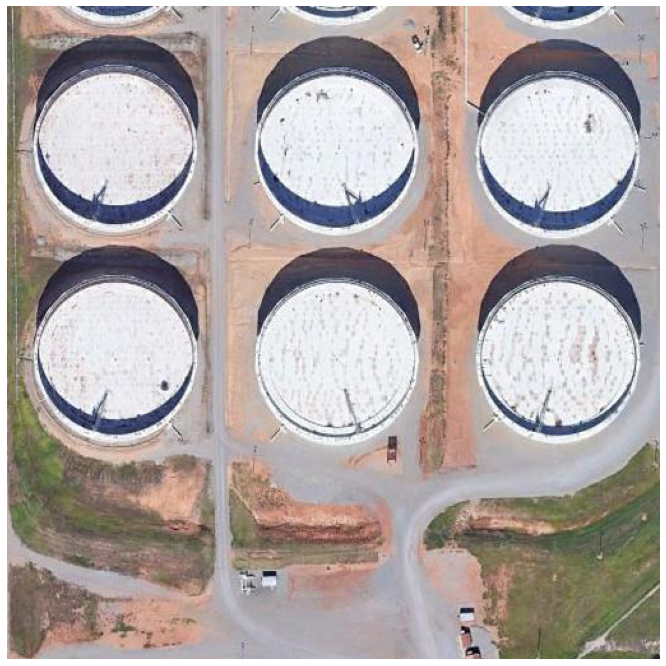

In [ ]:
im = open_image(path+'/image_patches/'+fname)
im.show(figsize=(12,12))

In [ ]:
tank = MultiTank(j[idx]['label']['Floating Head Tank'], im)

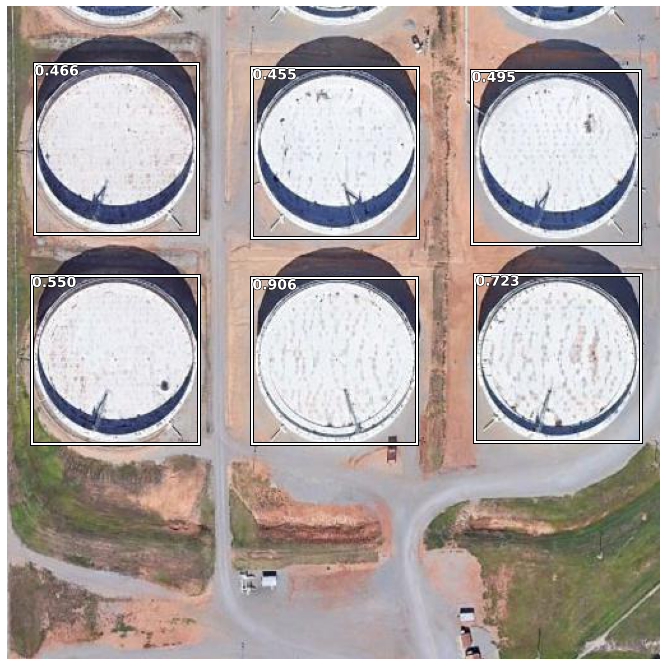

In [ ]:
tank.plot_volumes(figsize=(12,12));

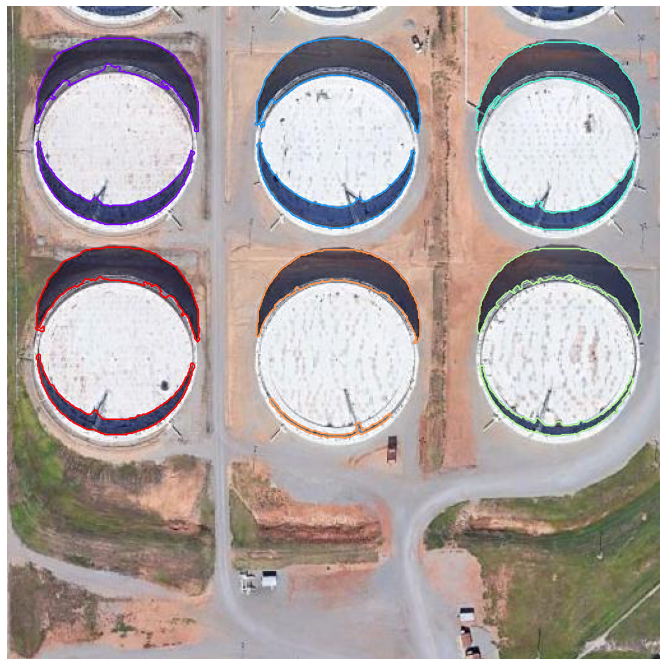

In [ ]:
tank.plot_contours()

In [ ]:
single_tank = tank.tanks[3]

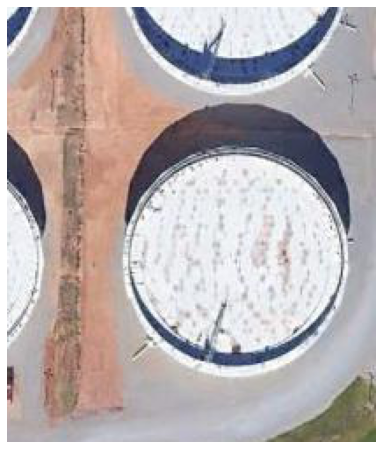

In [ ]:
fig, axes = plt.subplots(figsize=(8,8))
axes.imshow(single_tank.tank_crop)
axes.axis('off');

In [ ]:
single_tank.proc_tank()

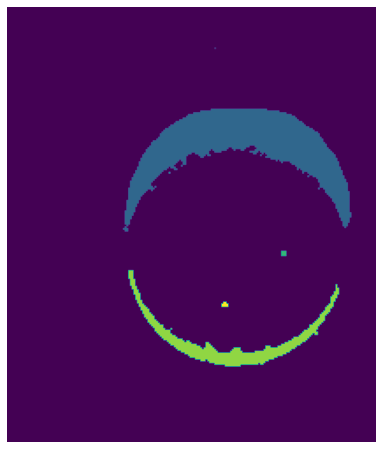

In [ ]:
fig, axes = plt.subplots(figsize=(8,8))
axes.imshow(single_tank.label_image)
axes.axis('off');

In [ ]:
regions_all = measure.regionprops(single_tank.label_image)
regions = []

for region in regions_all:
    if intersection(single_tank.bbox_relative, region.bbox) > 300:
        if region.area > 25:
            b = region.bbox
            if abs(single_tank.tank_thresh[b[0]:b[2], b[1]:b[3]].mean() - region.image.mean()) < 0.06:
                regions.append(region)

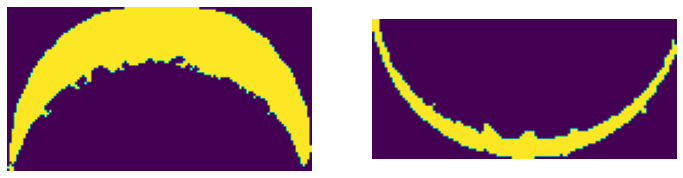

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 8))
axes[0].imshow(regions[0].image)
axes[1].imshow(regions[1].image)
for ax in axes.flat:
    ax.axis('off')